# Minería de datos - Actividad 2
Manuel J. Corral Pazos

# Introducción
Para realizar la actividad, escogemos un problema con la siguiente descripción:

Una clínica psiquiátrica asigna valores para el grado de enfermedad mental de sus pacientes y para el grado de desconfianza que tienen los pacientes hospitalizados en los médicos que los tratan. Seis meses más tarde, se asigna un valor actualizado para el grado de la enfermedad tras haber realizado algún tipo de tratamiento con los respectivos médicos. La cuestión que vamos a tratar es ver el efecto que tiene el grado de desconfianza en los médicos que tratan a los pacientes en los psiquiátricos en el desarrollo de sus enfermedades.
El objetivo de realizar este estudio es, en caso de detectar si mejora o empeora la evolución de los tratamientos dependiendo de la desconfianza, poder ofrecer un mejor tratamiento a los enfermos reasignándoles médicos en los que tengan más o menos confianza, dependiendo de los resultados del estudio.

El conjunto de datos elegido está disponible en el siguiente enlace:

people.sc.fsu.edu/~jburkardt/datasets/regression/x07.txt

Para poder procesarlos, realizamos una conversión a formato csv, y se entrega como documento adjunto datosEnfermedades.csv, sobre el que realizaremos el estudio.


# Análisis de los datos

En primer lugar, veamos la información general del conjunto de datos para poder decidir cómo enfocar el estudio.

In [52]:
import pandas as pd

In [53]:
#Cargamos el csv de los datos
datos = pd.read_csv('datosEnfermedades.csv',
                       delimiter=',',
                       header=0)
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Retardation  53 non-null     float64
 1   Distrust     53 non-null     float64
 2   Illness      53 non-null     int64  
dtypes: float64(2), int64(1)
memory usage: 1.4 KB


Como vemos en la salida de datos.info(), el DataFrame consta de:


*   53 entradas de datos
*   3 columnas correspondientes al grado de enfermedad mental, desconfianza en el médico y grado de enfermedad pasados 6 meses.
*   Las dos primeras variables son de tipo float y la última de tipo int, por lo que estamos ante datos continuos.

En este caso, todas las columnas del conjunto de datos son importantes y decidimos no eliminar ninguna de ellas, pues son las que utilizaremos para cumplir con el objetivo del estudio.

Para cada una de las columnas, analizaremos la distribución de los datos para obtener algo de información útil acerca de ellos.

In [54]:
datos.describe()

,Retardation,Distrust,Illness
count,53.000000,53.000000,53.000000
mean,2.992830,6.624528,22.716981
std,0.340708,0.773828,16.335871
min,2.180000,5.100000,4.000000
25%,2.740000,6.000000,11.000000
50%,2.900000,6.700000,20.000000
75%,3.260000,6.900000,27.000000
max,3.780000,8.800000,72.000000


Como vemos en la salida, la desviación típica de los valores Retardation y Distrust no es grande en comparación con la media, siendo la desviación estándar un 11% con respecto al valor medio. En cambio, en los valores de Illness, apreciamos un valor de desviación estándar que representa el 70,5% de la media, por lo que esperaremos una amplia dispersión en estos datos.

En efecto, esto podemos verlo en la diferencia entre mínimos y máximos de las tres variables.

Algo que llama la atención es la diferencia entre el percentil 75% y el valor máximo de la columna de Illness. Para estudiar esto, elaboramos un boxplot para ver la dispersión de las variables:

In [55]:
%matplotlib inline

import matplotlib.pyplot as plt #Librería para dibujar
import numpy as np  # Librería para operaciones matemáticas

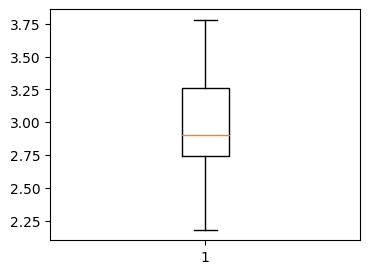

In [56]:
plt.rcParams['figure.figsize'] = [4, 3]
box = plt.boxplot(datos.Retardation)

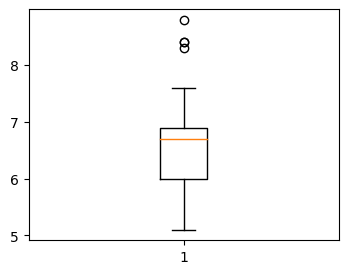

In [57]:
box = plt.boxplot(datos.Distrust)

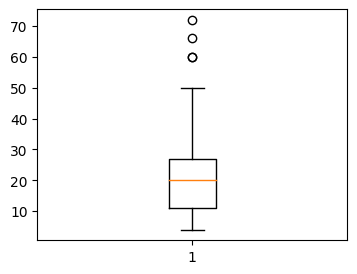

In [58]:
box = plt.boxplot(datos.Illness)

Como vemos, en las dos últimas variables se presentan algunos outliers en su distribución. Estudiémoslos:

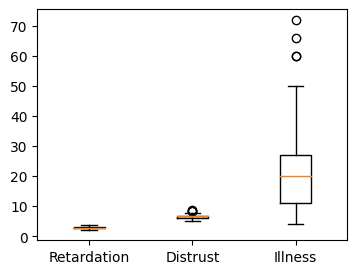

In [59]:
box = plt.boxplot(datos, labels=datos.columns)

In [60]:
out_retardation = box["fliers"][0].get_data()[1]
out_distrust = box["fliers"][1].get_data()[1]
out_illness = box["fliers"][2].get_data()[1]

print("Outliers en la variable 'Retardation': {}".format(out_retardation))
print("Outliers en la variable 'Distrust': {}".format(out_distrust))
print("Outliers en la variable 'Illness': {}".format(out_illness))

Outliers en la variable 'Retardation': []
Outliers en la variable 'Distrust': [8.4 8.4 8.3 8.8]
Outliers en la variable 'Illness': [72. 60. 60. 66.]


A la vista de esta salida, veremos si alguno de los outliers de Distrust e Illess es outlier en las dos variables simultáneamente. Como el volumen de datos en este caso no es muy grande, lo comprobamos a mano. De tener un conjunto de datos mayor, tendríamos que escribir alguna función en código para poder verlo.
En este caso, ninguno de los valores es outlier en ambas variables, así que no eliminaremos ninguno con el fin de mejorar la calidad del modelo.

Por todos estos motivos, parece que el conjunto de datos elegido ya ha recibido algún tipo de preprocesado: todas las columnas son relevantes para el estudio, no hay outliers y la dispersión de los datos es aceptable.

En la propia fuente de dónde se eligió conjunto de datos se nos indica que es apropiado para crear un modelo de regresión lineal. Sin embargo, vamos a ver si los datos son adecuados para utilizar un modelo de esta forma. Por esto, vamos a tratar de estudiar las relaciones lineales existentes entre la variable dependiente y las independientes una a una.
Para esto, utilizamos un diagrama de tipo scatter.

<Axes: xlabel='Retardation', ylabel='Illness'>

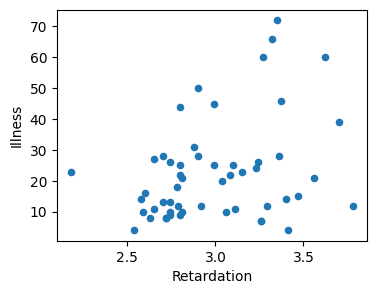

In [61]:
datos.plot(kind='scatter', x='Retardation', y='Illness')


<Axes: xlabel='Distrust', ylabel='Illness'>

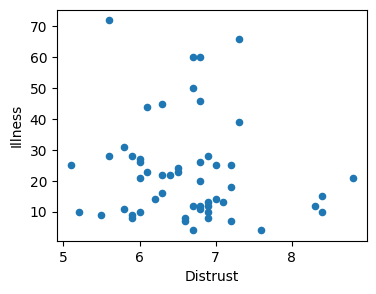

In [62]:
datos.plot(kind='scatter', x='Distrust', y='Illness')


Como vemos, la linealidad entre las variables independientes y la dependiente no parece que vaya a ser óptima para realizar un modelo con nuestras condiciones. No obstante y a la vista de los diagramas, podemos esperar que el coeficiente que multiplicará al a primera variable sea positivo, puesto que al aumentar Retardation aumenta Illness; mientras que en la segunda variable deberá ser negativo, pues al aumentar Distrust, disminuye Illness.
Por lo tanto, se propone en una primera instancia construir un modelo de regresión lineal y posteriormente estudiar si este resulta suficientemente efectivo para el estudio. Es posible que en un futuro sea necesario obtener un cojunto de datos más grande.


# Construcción del modelo

Para la construcción, buscamos un modelo de regresión lineal para ver cómo se comportan los datos. Para ello, utilizaremos la librería LinearRegresion de scikit-learn. También dividimos el conjunto de datos en datos de test y datos de entrenamiento. Utilizaremos train_test_split, también de sklearn para la división. Establecemos el valor del seed para que, en caso de querer replicar el estudio, se obtengan los mismos resultados.


In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
SEED_VALUE = 123


In [64]:
datos_train, datos_test = train_test_split(datos, test_size=0.3, random_state=SEED_VALUE)

print('Tamaño train: {}'.format(datos_train.shape[0]))
print('Tamaño test: {}'.format(datos_test.shape[0]))

X_train = datos_train[['Retardation', 'Distrust']]
Y_train = datos_train['Illness']

modelo = LinearRegression()
modelo.fit(X_train,Y_train)

coef = pd.DataFrame([modelo.intercept_, *modelo.coef_], ['(Intercept)', *X_train.columns], columns=['Coefficients'])
coef

Tamaño train: 37
Tamaño test: 16


,Coefficients
(Intercept),-6.492796
Retardation,19.244693
Distrust,-4.497420


En efecto, tal y como esperábamos el parámetro correspondiente a la primera variable es positivo y el segundo es negativo. Por tanto, la fórmula de regresión lineal de nuestro modelo será:

Illness = (-6.492796) + (19.244693) Retardation + (-4.497420) Distrust

Ahora pasamos a realizar la predicción del modelo y calculamos la correlación entre los datos que hemos predicho y los datos originales de test.

In [65]:
X_test = datos_test[['Retardation', 'Distrust']]
Y_test = datos_test['Illness']


np.random.seed(SEED_VALUE)
pred = modelo.predict(X_test)
print(pred)
print()
print("Correlacion: ")
Y_test.corr(pd.Series(pred, Y_test.index))

[19.18410318 27.45722399 21.3637702  28.92356194 18.93310022 24.56842262
 20.85756956 16.16980034 21.50185581 14.30598439 19.95808563 32.79137681
 27.77936711  8.45933886 18.66951312 22.50796503]

Correlacion: 


0.4761824650858669

También realizamos un análisis estadístico utilizando una api diseñada para este tipo de modelos. En nuestro caso elegimos utilizar mínimos cuadrados ordinario (OLS).

In [66]:
import statsmodels.api as sm

X = datos[['Retardation', 'Distrust']]
Y = datos['Illness']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
predictions = model.predict(X)

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                Illness   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     6.206
Date:                Sat, 09 Dec 2023   Prob (F-statistic):            0.00391
Time:                        11:02:14   Log-Likelihood:                -216.87
No. Observations:                  53   AIC:                             439.7
Df Residuals:                      50   BIC:                             445.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.8253     21.044     -0.039      

Dentro de estos datos, destacamos el término R-squared, el cuál es el coeficiente de determinación que nos indica el porcentaje de variación en la que la variable dependiente puede ser explicada por las variables independientes. En este caso, tenemos un 20% de variación, lo que indica que ese porcentaje de la variable Illness puede ser explicada a partir de las otras dos.

Para más información sobre esta api, https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html#

Gracias al uso de estos estadísticos, podemos ver por qué obtuvimos una correlación relativamente baja (0.48) entre los datos predichos por el modelo y los datos reales, puesto que tan solo un 20% del comportamiento de la variable dependiente está explicado por las independientes. Traducido al enunciado de nuestro problema, tan solo un 20% del índice de la enfermedad medida a los 6 meses del tratamiento se explica a partir de combinar el índice original de la enfermedad con el grado de desconfianza en el doctor asignado. Como ya se había comentado anteriormente, sería interesante poder realizar el estudio con una mayor cantidad de datos para una mejor verificación del resultado.

Por todo esto y a la espera de revisión de un profesional de salud mental, concluimos que en los hospitales en los que se dé esta problemática, podemos tomar la decisión de reasignar a los pacientes un médico con el que tengan menos grado de desconfianza y esto puede suponer una leve mejoría en su evolución. Quedaría a elección de la dirección del hospital el tomar esta decisión, en función de si la reasignación de médicos supone un coste económico o de trabajo demasiado elevado o no, en comparación a los beneficios obtenidos en los pacientes.